# bird detector

## 安裝

In [ ]:
!pip install -Uqq fastai duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.0 MB/s eta 0:00:00


## 下載鳥、非鳥 (森林) 的圖

`L`：python 列表的替代品；支持進階 indexing，具有額外的方法以便於簡單的表達程式碼

[docs](https://fastcore.fast.ai/foundation.html#l)

In [ ]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
  print(f"Searching for '{term}'")
  return L(next(DDGS().images(term)) for _ in range(max_images)).itemgot('image')

"鳥" 的圖：

Searching for 'bird photos'


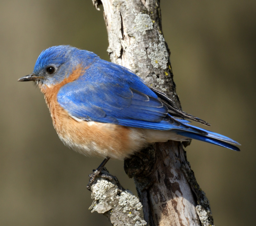

In [ ]:
from fastdownload import download_url
from fastai.vision.all import *

dest = 'bird.jpg'
download_url(search_images('bird photos', max_images=1)[0], dest, show_progress=False)
Image.open(dest).to_thumb(256,256)

"森林" 的圖：

Searching for 'forest photos'


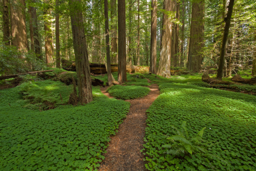

In [ ]:
dest = 'forest.jpg'
download_url(search_images('forest photos', max_images=1)[0], dest, show_progress=False)
Image.open(dest).to_thumb(256,256)

取得多張 "鳥"、"森林" 的圖片，分別存在不同的目錄 (目錄名稱為 label)

In [ ]:
from time import sleep

searches = 'forest','bird'
path = Path('bird_or_not')
if not path.exists():
  for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10) # 防止server過載
    download_images(dest, urls=search_images(f'{o} sun photo')) # 考慮不同光線
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(dest, max_size=400, dest=dest)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


下載壞的圖會造成訓練失敗，要移除掉

In [ ]:
failed = verify_images(get_image_files(path))
len(failed.map(Path.unlink))

0

## 訓練

`DataBlock`：創建 DataLoaders 的設定

`DataLoaders`：包含 training/validation 的 `DataLoader` 列表，預設指向 training `DataLoader`

`DataLoader`：提供 batch 資料給 GPU

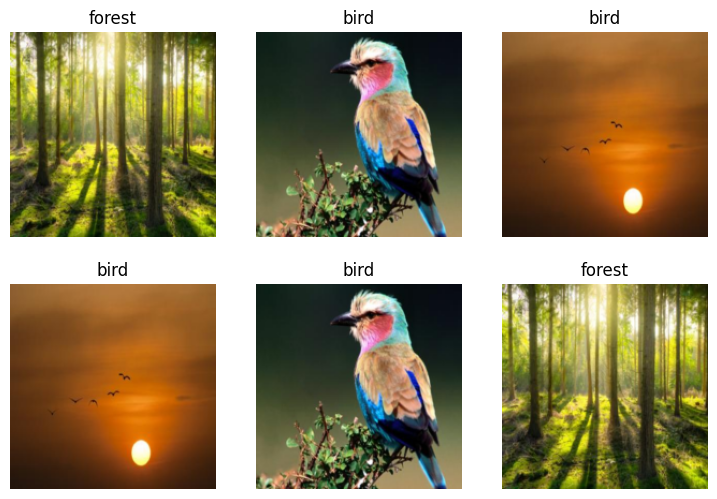

In [ ]:
dls = DataBlock(
  blocks=(ImageBlock, CategoryBlock), # 輸入是 image，輸出是 category
  get_items=get_image_files, # 利用 get_image_files 取得輸入的檔案
  splitter=RandomSplitter(valid_pct=0.2, seed=42), # 20% 資料切為 validation set；為了使每次執行都同樣切分 training/validation set，設定亂數種子
  get_y=parent_label, # 使用檔案目錄的名稱作為 label
  item_tfms=[Resize(192, method='squish')] # 每個資料訓練前調整大小
).dataloaders(path)
dls.show_batch(max_n=6)

使用 pretrained model 時，將刪除最後一個 layer (因為它是針對原始訓練任務專門定制的)，將其替換為具有隨機 weight (適合當前數據集) 的多個新 layer (head)

訓練時需搭配 fine_tune() 使用 transfer learning 的技巧進行微調：
- 做一次 epoch 來訓練讓新的 head 適應你的數據集
- 使用在調用方法時請求的 epoch 數，來訓練整個模型 (通常不太更改 pretrained weights)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate) # ResNet 架構，18 layer；預設下載 pretrained model 的權重
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 76.2MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.444502,1.462675,0.774194,00:08


epoch,train_loss,valid_loss,error_rate,time
0,1.176657,0.708305,0.290323,00:01
1,0.661679,0.143897,0.064516,00:00
2,0.447438,0.043443,0.000000,00:00


## 預測

In [ ]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")
dls.vocab # 顯示 categories

This is a: bird.
Probability it's a bird: 0.9623


['bird', 'forest']

## 幾種文件方式

In [10]:
# 說明
?learn.predict

In [11]:
# 包含 source 的說明
??learn.predict

In [ ]:
!pip install -q nbdev
doc(learn.predict) # 可以看 fastai 方法

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.0 MB/s eta 0:00:00


# sentiment analysis - movie review

## 安裝

In [ ]:
!pip install -Uqq fastai

## 下載

In [ ]:
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')

## 訓練

In [8]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.457465,0.408514,0.819400,03:27


epoch,train_loss,valid_loss,accuracy,time
0,0.304513,0.244331,0.901640,06:58
1,0.242277,0.200962,0.920480,06:59
2,0.178344,0.204678,0.923000,06:59
3,0.135568,0.192145,0.930280,06:59


## 預測

In [9]:
learn.predict("I really liked that movie!")

('pos', tensor(1), tensor([0.0136, 0.9864]))

# segmentation

## 安裝

In [12]:
!pip install -Uqq fastai

## 下載

In [13]:
from fastai.vision.all import *

path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
  path, bs=8, fnames = get_image_files(path/"images"),
  label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
  codes = np.loadtxt(path/'codes.txt', dtype=str)
)

## 訓練

In [14]:
learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 82.5MB/s]


epoch,train_loss,valid_loss,time
0,3.666543,2.692599,00:04


epoch,train_loss,valid_loss,time
0,1.963070,1.679574,00:03
1,1.665275,1.346874,00:02
2,1.544998,1.506041,00:02
3,1.435019,1.237353,00:04
4,1.314847,1.014305,00:04
5,1.202428,0.950128,00:02
6,1.104506,0.893827,00:02
7,1.024418,0.893136,00:01


## 顯示結果

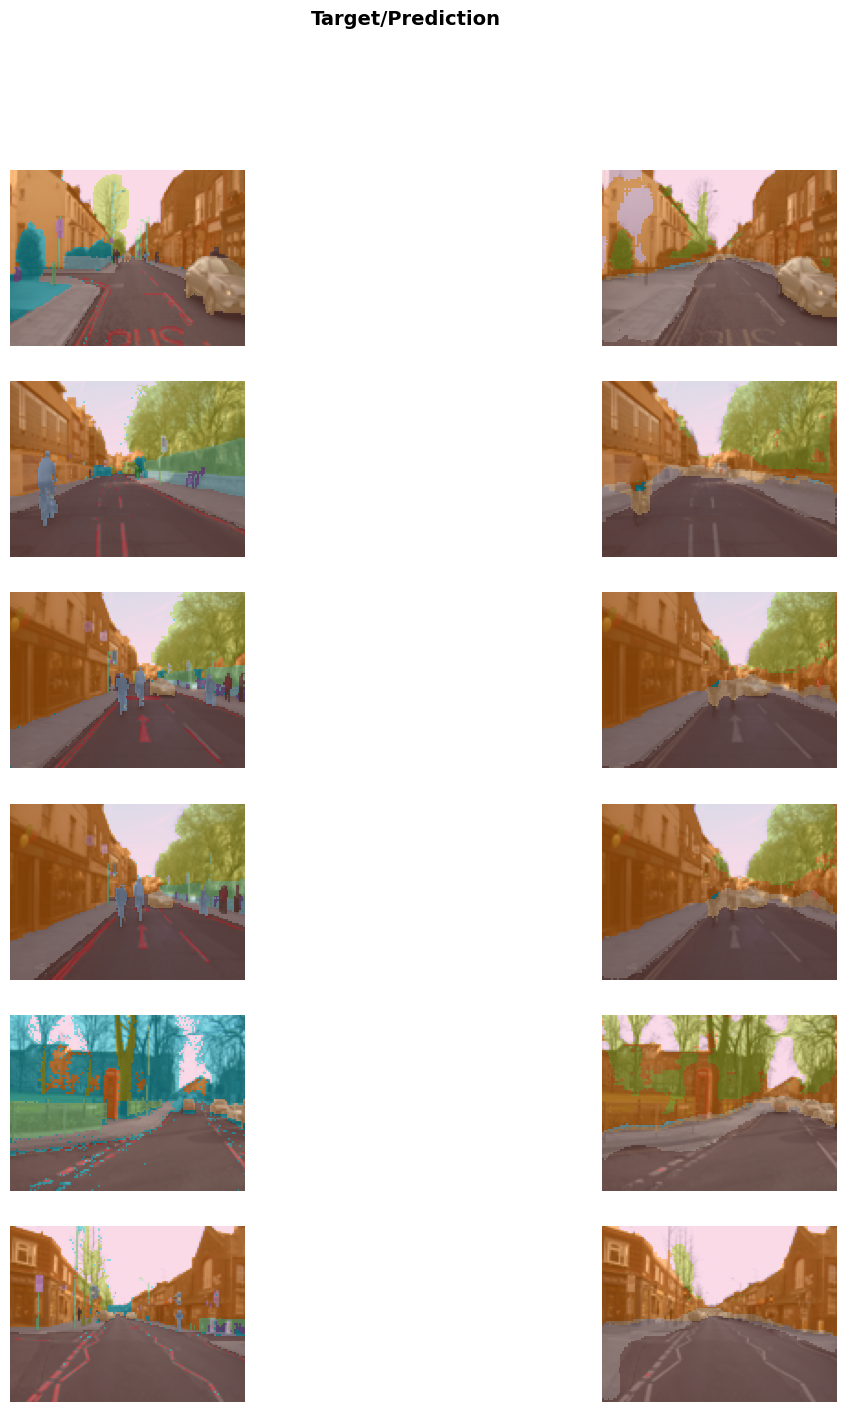

In [21]:
learn.show_results(max_n=6, figsize=(14,16))

# tabular analysis - income prediction

## 安裝

In [22]:
!pip install -Uqq fastai

## 下載

In [23]:
from fastai.tabular.all import *

path = untar_data(URLs.ADULT_SAMPLE)
dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
  cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'], # categorical column
  cont_names = ['age', 'fnlwgt', 'education-num'], # continuous column
  procs = [Categorify, FillMissing, Normalize])
dls.show_batch()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,Federal-gov,HS-grad,Never-married,Armed-Forces,Not-in-family,White,False,39.000000,227596.998708,9.0,<50k
1,Private,HS-grad,Never-married,Other-service,Unmarried,Black,False,31.000000,363130.004375,9.0,<50k
2,Private,10th,Married-civ-spouse,Machine-op-inspct,Husband,White,False,59.000000,186385.000016,6.0,<50k
3,Private,HS-grad,Never-married,Priv-house-serv,Not-in-family,White,False,25.000000,132683.002655,9.0,<50k
4,Local-gov,Doctorate,Never-married,Prof-specialty,Not-in-family,White,False,31.000000,446357.989216,16.0,>=50k
5,Private,Some-college,Never-married,Tech-support,Not-in-family,White,False,20.000001,107657.999050,10.0,<50k
6,Local-gov,Bachelors,Divorced,Prof-specialty,Unmarried,White,False,53.000000,35304.998979,13.0,<50k
7,Private,HS-grad,Never-married,Prof-specialty,Not-in-family,White,False,17.999999,434429.995705,9.0,<50k
8,Private,HS-grad,Divorced,Adm-clerical,Not-in-family,White,False,47.000000,181652.000069,9.0,<50k
9,Private,HS-grad,Divorced,#na#,Not-in-family,Black,False,59.000000,188041.000038,9.0,<50k


## 訓練

In [24]:
learn = tabular_learner(dls, metrics=accuracy)
learn.fit_one_cycle(3) # tabular modeling task 通常沒有 pretrained model

epoch,train_loss,valid_loss,accuracy,time
0,0.388438,0.369542,0.834920,00:06
1,0.368390,0.358513,0.832463,00:12
2,0.357301,0.354924,0.838298,00:10


# collaborative filtering - recommendation system

## 安裝

In [25]:
!pip install -Uqq fastai

## 下載

In [26]:
from fastai.collab import *

path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')
dls.show_batch()

,userId,movieId,rating
0,475,589,4.5
1,580,6539,3.0
2,73,608,4.0
3,15,4226,5.0
4,312,1213,5.0
5,78,2858,4.5
6,648,1580,1.5
7,509,2028,3.0
8,292,1196,4.5
9,88,5349,3.0


## 訓練

In [27]:
learn = collab_learner(dls, y_range=(0.5,5.5)) # 預測連續值時，要設定目標範圍
learn.fine_tune(10) # 儘管實際上並沒有使用 pretrained model，但 fastai 讓我們在這種情況下無論如何都可以使用 fine_tune()

epoch,train_loss,valid_loss,time
0,1.520988,1.399558,00:00


epoch,train_loss,valid_loss,time
0,1.362671,1.336640,00:00
1,1.263107,1.149380,00:00
2,1.024904,0.838906,00:00
3,0.808276,0.690978,00:00
4,0.700105,0.652473,00:00
5,0.647886,0.640037,00:00
6,0.635380,0.634373,00:00
7,0.621240,0.632050,00:00
8,0.618783,0.630826,00:01
9,0.619206,0.630716,00:01


## 顯示結果

In [28]:
learn.show_results()

,userId,movieId,rating,rating_pred
0,27.0,87.0,4.0,3.286280
1,16.0,50.0,3.0,3.903063
2,79.0,75.0,4.5,4.454323
3,87.0,64.0,5.0,4.055040
4,86.0,46.0,3.0,3.264051
5,1.0,62.0,4.0,3.773461
6,68.0,68.0,5.0,3.514568
7,92.0,95.0,4.5,4.211733
8,63.0,67.0,2.0,2.851316
